<h1>Ising Model: Monte Carlo Simulations</h1>
<h4>William Pugsley </h4>

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

#Thermodynamic constants
k_B = 1.380649e-23 #Units: J/K

In [2]:
#the following functions will help simplify our code throughout our simulation 
from math import sqrt


def mean(data):
    """ (list) -> (float)
    Returns the mean of the values in data.
    
    >>> ex = [0.1, 0.4, 0.6, 0.8, 1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.9, 2.0, 2.2, 2.6, 3.2]
    >>> mean(ex)
    1.5
    """
    return sum(data)/len(data)


def standard_dev(data, ave=None):
    """ (list, float/None) -> float
    Returns the standard deviation of the values in data.
    
    >>> ex = [0.1, 0.4, 0.6, 0.8, 1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.9, 2.0, 2.2, 2.6, 3.2]
    >>> standard_dev(ex)
    0.8434622525214579
    """
    if ave is None: #an average is not given and we must calculate it
        ave = mean(data) #finds the average of data
    #otherwise an average is already given as input
    
    #The following code computes the standard deviation of data
    std = 0
    for entry in data:
        std += (entry - ave)**2
        
    return sqrt(std/(len(data)-1))


def variance(data):
    """ (list) -> (float)
    """
    return standard_dev(data)**2

def standard_error(data, std=None):
    """ (list, float/None) -> (float)
    Returns the standard error of the values in data.
    
    >>> ex = [0.1, 0.4, 0.6, 0.8, 1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.9, 2.0, 2.2, 2.6, 3.2]
    >>> standard_error(ex)
    0.21778101714468007
    """
    if std is None:
        std = standard_dev(data)
    return std/sqrt(len(data))


def normalised_residuals(x, y, fit, error):
    """ (list, list, function, list) -> (list)
    Finds the residuals of a best fit single-variable function with non-uniform error and
    returns their y-coordiantes. The error array is the standard error of the predicted values
    at each point in x.
    """
    yRes = []
    for i in range(len(x)):
        yRes.append((y[i] - fit(x[i]))/error[i])
    
    return yRes


def durbin_watson(res):
    """ (list) -> (float)
    Returns the Durbin-Watson statistic which uses the residuals to test the fit of a function.
    D=0 : systematically correlated residuals
    D=2 : randomly distributed residuals that follow a Gaussian distribution
    D=4 : systematically anticorrelated residuals
    """
    numerator = 0
    for i in range(1, len(res)):
        numerator += (res[i] - res[i-1])**2
    
    denominator = 0
    for i in range(len(res)):
        denominator += res[i]**2
    
    return numerator/denominator

<h2>Algorithm</h2>

The Monte Carlo algorithm we will use (Holmes-Cerfon 6-9) consists of creating a grid of positive and negative spins, this will be realized as a d-dimensional numpy array of +1 and -1 randomly. This algorithm will apply to any dimension d. We will iterate through each spin and calculate the energy change, $\Delta E$ associated with flipping the spin. The new state will be accepted with probability $Prob=W(\sigma',\sigma)$, where $W(\sigma',\sigma)$ satisfies the detailed balance equation (Grant 41); for our purposes this will be either the Glauber rule or the Metropolis rule. 

$W_{Metropolis}(\sigma',\sigma)=1 \; \Delta E \leq 0, \: e^{\frac{-\Delta E}{k_BT}} \; \Delta E \gt 0$

$W_{Glauber}(\sigma',\sigma)=\frac{1}{2}(1-tanh(\frac{\Delta E}{2k_BT}))$

We will do this for each spin in the strip, this is one Monte Carlo cycle. Completing N cycles for our N spins will consist of one Monte Carlo simulation (Grant 45). At the end of a simulation we can calculate the total magnetization and the magnetization per spin; with these quantities we can verify our theoretical expectation of $<m>$. Repeating for diferent temperatures should yield the temperature dependence of $<m>$. The correlation function, $<S_iS_{i+r}>$ can also be calculated from the same simulation.

<h2>1-Dimensional Ising Model</h2>

The one-dimensional Ising model consists of a strip of N sites each containing a spin, $S_i$, pointing in either the positive or negative direction. The energy of a state is defined such that neighboring spins pointing in the same direction as well as spins pointing in the direction of an external field, H, are favored.

$E_{state}=-J\sum_{j=1}^{N}S_jS_{j+1} - H\sum_{j=1}^NS_i$ 

J is strength of interactions between neighboring spins. This system can be solved exactly (Salinas 260-263):

$Z_N=A_1^N+_2^N$

$A_1=e^{\frac{J}{k_BT}}cosh(\frac{H}{k_BT})+[e^{2\frac{J}{k_BT}}cosh^2(\frac{H}{k_BT})-2sinh(2\frac{J}{k_BT})]^{1/2}$

$A_2=e^{\frac{J}{k_BT}}cosh(\frac{H}{k_BT})-[e^{2\frac{J}{k_BT}}cosh^2(\frac{H}{k_BT})-2sinh(2\frac{J}{k_BT})]^{1/2}$

$m(T,H)=\frac{sinh(\frac{H}{k_BT})}{[sinh^2(\frac{H}{k_BT})+e^{-4\frac{J}{k_BT}}]^{1/2}}$

$<S_iS_{i+r}>=\frac{A_1^{N-r}A_2^r+A_1^rA_2^{N-r}}{A_1^N+A_2^N}$, r is the distance between two sites.

$\lim_{N \to \infty} <S_iS_{i+r}> = (\frac{A_2}{A_1})^r = (\frac{e^{\frac{J}{k_BT}}cosh(\frac{H}{k_BT})-[e^{2\frac{J}{k_BT}}cosh^2(\frac{H}{k_BT})-2sinh(2\frac{J}{k_BT})]^{1/2}}{e^{\frac{J}{k_BT}}cosh(\frac{H}{k_BT})+[e^{2\frac{J}{k_BT}}cosh^2(\frac{H}{k_BT})-2sinh(2\frac{J}{k_BT})]^{1/2}})^r$

If we consider the case where the external field H=0, we can easily simplify the thermodynamic quantities:

$Z_N=(2*cosh(\frac{J}{k_BT}))^N$

$<m>=0$

$<S_iS_{i+r}>=(tanh(\frac{J}{k_BT}))^r=e^{-r/\xi}, \; \xi=\frac{1}{|ln(tanh(\frac{J}{k_BT}))|}$

Throughout the simulation thermodynamic variables will be defined in units of $J$ and $k_B$. For example, temperature will always be defined in units of $J/k_B$ so $T=a*J/k_B$ for some real number a. This reduces the thermodynamic variables to workable forms.

$Z_N=(2*cosh(\frac{1}{a}))^N$

$<m>=0$

$<S_iS_{i+r}>=(tanh(\frac{1}{a}))^r=e^{-r/\xi}, \; \xi=\frac{1}{|ln(tanh(\frac{1}{a}))|}$


<h4>Setup</h4>

In [3]:
def init_grid_1d(length):
    """ (int) -> (np.array)
    Creates an numpy array with 'length' entries of randomly chosen +1 and -1 spins.
    """
    return np.array([random.randrange(-1, 2, 2) for i in range(length)])

def total_mag_1d(grid):
    """ (np.array) -> (int)
    Calculates the total magnetization of a 1-dimensional grid of +1/-1 spins.
    """
    return sum(grid)

def mag_per_spin_1d(grid):
    """ (np.array) -> (float)
    Calculates the magnetization per spin of a 1-dimensional grid of +1/-1 spins.
    """
    return sum(grid)/len(grid)

def print_grid_1d(grid):
    """ (np.array) -> (None)
    Prints a visulation of the one-dimensional grid given as input.
    """
    s = "|"
    for spin in grid:
        if spin == 1:
            s += " + |"
        else:
            s += " - |"
    print(s)

In [4]:
def energy_change_1d(grid, idx, H=0):
    """ (np.array, int, float) -> (int)
    Calculates the energy change associated with flipping the spin at the idx position. The change is in units of J.
    H is the external field pointing in either the positive or negative direction also in units of J.
    """
    n = len(grid)
    return 2*grid[idx]*grid[(idx+1)%n] + 2*H*grid[idx] 



from math import tanh
#we can use the Glauber rule to calculate the probability of a state transition
def glauber_1d(grid, idx, temp, H=0):
    """ (np.array, int, float, float) -> (float)
    Calculates the probability that a change of state of a 1-dimensional grid, with energy change given by energy, will occur at a given temperature, temp. The probability is calculated using the Glauber rule. 
    """
    energy = energy_change_1d(grid, idx, H)
    return 0.5*(1 - tanh(0.5*energy/temp))


from math import exp
#we can also use metropolis rule
def metropolis_1d(grid, idx, temp, H=0):
    """ (np.array, int, float, float) -> (float)
    Calculates the probability that a change of state of a 1-dimensional grid, with energy change given by energy, will occur at a given temperature, temp. The probability is calculated using the Metropolis rule. 
    """
    energy = energy_change_1d(grid, idx, H)
    if energy <= 0:
        return 1
    return exp(-energy/temp)


def flip_1d(grid, idx, temp, H=0, rule="metropolis"):
    """ (np.array, int, float, float) -> ()
    Flips the spin in grid at site idx with a probability given by the Glauber or Metropolis rule at temperature temp.
    """
    if rule == "glauber":
        prob = glauber_1d(grid, idx, temp, H)
    elif rule == "metropolis":
        prob = metropolis_1d(grid, idx, temp, H)
    else:
        raise ValueError("The rule argument take \"glauber\" or \"metropolis\" as input.") 

    choice = random.uniform(0, 1)
    
    if choice <= prob: #will flip
        grid[idx] *= -1
    #otherwise will not flip and nothing happens


def cycle_1d(grid, temp, H=0):
    """ (np.array, float, float) -> ()
    Will conduct one Monte Carlo cycle over grid at temperature temp. 
    """
    length = len(grid) 
    for idx in range(length): #test flip at each site
        flip_1d(grid, idx, temp, H)


def simulation_1d(grid, temp, H=0):
    """ (np.array, float, float) -> ()
    Will conduct one Monte Carlo simulation over grid at temperature temp. 
    """
    length = len(grid)
    for i in range(length): #N Monte Carlo cycles for N sites is one simulation
        cycle_1d(grid, temp, H)

In [5]:
def correlation_1d(grid, r):
    """ (np.array, int) -> (float)
    Returns the expected value of correlations <Si*Si+r> of a one-dimensional strip.
    """
    length = len(grid)
    return mean([grid[i]*grid[(i+r)%length] for i in range(length)])

<h4>Simulation</h4>

We will create a one-dimensional strip of N sites and run a total of num_sim Monte Carlo simulations before recording the magnetization per spin. We will do this num_points times, to get that many data points, at each temperature T in temperatues. Increasing num_points will get us a more precise measurement of the magnetization per spin at different temperatures. Increasing num_sim will let our experimental results approach the long-time thermodynamic limit 

In [6]:
def full_sim_1d(N, num_points, num_sim, temperatures, H=0, output='mag'):
    """ (int, int, int, np.array) -> (list, list) or (list, list, list, list)
    N: total number of spin sites
    num_points: number of data points at each temperature
    num_sim: total numer of simulations conducted on a strip
    temperatures: range of temperatues at which we will simulate
    H: the strength of the external field
    output: the variable we are measuring (magnetization per spin, correlation function, or both) 
    """
    if output == "mag":
        magnetizations = [] #<m> of our simulations at various temperatues
        magnetizations_unc = [] #uncertainties in <m>

        for T in temperatures:
            m_at_t = []
            for i in range(num_points): #we do num_points simulations at each temperature for that many data points
                strip = init_grid_1d(N)
                for i in range(num_sim): #we do num_sim simulations for each strip
                    simulation_1d(strip, T, H)
                m_at_t.append(mag_per_spin_1d(strip))
            magnetizations.append(mean(m_at_t))
            magnetizations_unc.append(standard_error(m_at_t))
        return magnetizations, magnetizations_unc
    elif output == "corr": #finds the correlation function of the 1D Ising model at the first value in temperatures
        correlations = [[] for i in range(N)] #list of all the data points at each r
        T = temperatures[0]

        for i in range(num_points): #we want num_points data points at each r
            strip = init_grid_1d(N)
            for i in range(num_sim): #we do num_sim simulations for each strip
                simulation_1d(strip, T, H)
            for r in range(N):
                correlations[r].append(correlation_1d(strip, r))

        correlations_unc = [standard_error(x) for x in correlations] #uncertainty at each r
        for i in range(len(correlations)): #average at each r
            correlations[i] = abs(mean(correlations[i]))

        return correlations, correlations_unc
    raise ValueError("The output paramter must be \"mag\" or \"corr\".")

<h4>H=0</h4>

Since we have solved the one-dimensional Ising model, $H=0$, exactly we already know what our function for <m\> and <Si*Si+r\> ought to be. We can implement this function and use it to compute the expected values at various temperatures, T, and compare with our simulation results. We will start with looking at the expected value for the magnetization per spin. This value should be uniformely zero at all temperatures greater than zero.

In [26]:
#these values will be stored in separate variables so that we may easily change them
length = 10
num_points = 10
num_sim = 1
temperatures_h_0 = np.linspace(0.1, 2, 19) #the range of temperatures over which we will run our simulation

magnetizations, magnetizations_unc = full_sim_1d(length, num_points, num_sim, temperatures_h_0) #run the simulation

In [27]:
def expected_m_h_0_1d(temp): #expected magnetization is uniformely zero
    return 0

exp_m = [0 for T in temperatures_h_0]

residuals_1d = normalised_residuals(temperatures_h_0, magnetizations, expected_m_h_0_1d, magnetizations_unc)
#the residuals will have the same uncertainty as their respective energy values; the uncertainty in our expectation value for E is 0

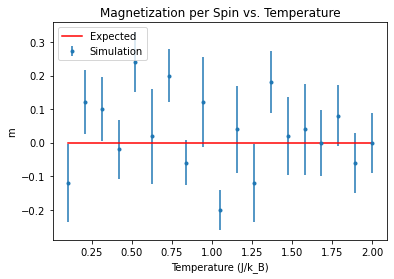

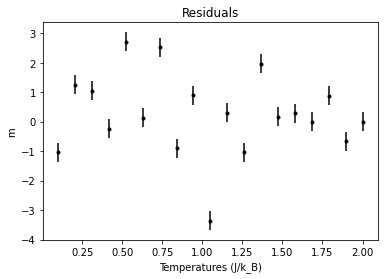

In [28]:
plt.figure()

plt.errorbar(x=temperatures_h_0, y=magnetizations, yerr=magnetizations_unc, marker='.', ls='', label='Simulation') #simulation results for <m>
plt.plot(temperatures_h_0, exp_m, 'r-', label='Expected') #expected: <m>=0

plt.legend(loc='upper left')
plt.title("Magnetization per Spin vs. Temperature")
plt.ylabel("m")
plt.xlabel("Temperature (J/k_B)")

plt.show()


plt.figure()

#the following two lines of code are so our residuals will have error bars
res_1d_stderror = standard_error(residuals_1d)
residuals_1d_unc = [res_1d_stderror for i in residuals_1d]

plt.errorbar(x=temperatures_h_0, y=residuals_1d, yerr=residuals_1d_unc, color='k', marker='.', ls='') #plotting residuals of <m>

plt.title('Residuals')
plt.xlabel('Temperatures (J/k_B)')
plt.ylabel('m')
plt.show()

Next we will consider the correlation function.

In [29]:
#these values will be stored in separate variables so that we may easily change them
length = 20
num_points = 100
num_sim = 10

#correlation function at low, medium, and high temperatures
corr_low_t, corr_low_t_unc = full_sim_1d(length, num_points, num_sim, [0.1], output="corr")
corr_med_t, corr_med_t_unc = full_sim_1d(length, num_points, num_sim, [1], output="corr")
corr_high_t, corr_high_t_unc = full_sim_1d(length, num_points, num_sim, [10], output="corr")

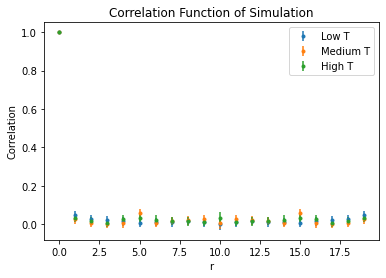

In [30]:
r = range(length)

plt.figure()

#correlation results at various temperatures
plt.errorbar(x=r, y=corr_low_t, yerr=corr_low_t_unc, marker='.', ls='None', label="Low T") 
plt.errorbar(x=r, y=corr_med_t, yerr=corr_med_t_unc, marker='.', ls='None', label="Medium T") 
plt.errorbar(x=r, y=corr_high_t, yerr=corr_high_t_unc, marker='.', ls='None', label="High T") 

plt.title("Correlation Function of Simulation")
plt.xlabel("r")
plt.ylabel("Correlation")

plt.legend()
plt.show()

The expected value of the correlation function is:

$<S_iS_{i+r}>=(tanh(\frac{1}{a}))^r=e^{-r/\xi}, \; \xi=\frac{1}{|ln(tanh(\frac{1}{a}))|}$

We can fit our results at various temperatures and extract different values for the correlation length, $\xi$.

In [12]:
from math import log
def expected_corr_length_h_0_1d(temp):
    """ (float) -> (float)
    Returns the expected value for the correlation length at temperature, temp, for the one-dimensional H=0 case.
    """
    return abs(1/log(tanh(1/temp)))


def corr_function_h_0_1d(x, length):
    """ (float, float) -> (float)
    Computes the correlation function at a distance, x, with correlation length, length, for the one-dimensional H=0 case.
    """
    return np.exp(-x/length)

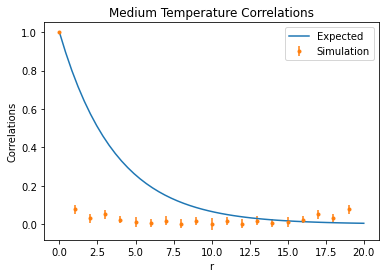

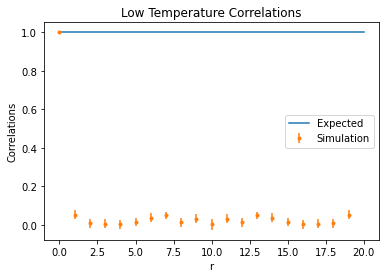

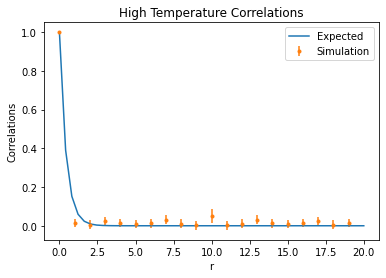

In [13]:
x = np.linspace(0, length)

#medium T
y = corr_function_h_0_1d(x, expected_corr_length_h_0_1d(1)) #returns np array of expected correlations
plt.figure()

plt.plot(x,y, label="Expected")
plt.errorbar(x=r, y=corr_med_t, yerr=corr_med_t_unc, ls='None', marker='.', label="Simulation")

plt.title("Medium Temperature Correlations")
plt.xlabel("r")
plt.ylabel("Correlations")
plt.legend()

plt.show() 


#Low T
y = corr_function_h_0_1d(x, expected_corr_length_h_0_1d(0.1))
plt.figure()

plt.plot(x,y, label="Expected")
plt.errorbar(x=r, y=corr_low_t, yerr=corr_low_t_unc, ls='None', marker='.', label="Simulation")

plt.title("Low Temperature Correlations")
plt.xlabel("r")
plt.ylabel("Correlations")
plt.legend()

plt.show() 


#High T
y = corr_function_h_0_1d(x, expected_corr_length_h_0_1d(10))
plt.figure()

plt.plot(x,y, label="Expected")
plt.errorbar(x=r, y=corr_high_t, yerr=corr_high_t_unc, ls='None', marker='.', label="Simulation")

plt.title("High Temperature Correlations")
plt.xlabel("r")
plt.ylabel("Correlations")
plt.legend()

plt.show() 

<h4>H&#8800;0</h4>

Firstly, we will compare our simulation results for our magnetization per spin at various values of H to our expectation values.

$m(T,H)=\frac{sinh(\frac{H}{k_BT})}{[sinh^2(\frac{H}{k_BT})+e^{-4\frac{J}{k_BT}}]^{1/2}}$


In [31]:
from math import cosh, sinh
def expected_m_1d(temp, field):
    """ (num, num) -> (num)
    Finds the expected value for the magnetization per spin of the one-dimensional Ising model at temperature, temp, and with
    external field, field. temp is in units of J/k_B and H is in units of J.
    """
    return sinh(field/temp)/sqrt(sinh(field/temp)**2 + exp(-4/temp))

In [32]:
#these values will be stored in separate variables so that we may easily change them
length = 20
num_points = 10
num_sim = 1
temperatures = np.linspace(0.1, 2, 19) #the range of temperatures over which we will run our simulation

mag_minus5, mag_unc_minus5 = full_sim_1d(length, num_points, num_sim, temperatures, -5) #H=-5
mag_minus1, mag_unc_minus1 = full_sim_1d(length, num_points, num_sim, temperatures, -1) #H=-1
mag_1, mag_unc_1 = full_sim_1d(length, num_points, num_sim, temperatures, 1) #H=1
mag_5, mag_unc_5 = full_sim_1d(length, num_points, num_sim, temperatures, 5) #H=5

In [33]:
#these are the expected values for the magnetization per spin at various temperatures and H

expected5 = []
for t in temperatures:
    expected5.append(expected_m_1d(t,5))

expected1 = []
for t in temperatures:
    expected1.append(expected_m_1d(t,1))

expected_minus1 = []
for t in temperatures:
    expected_minus1.append(expected_m_1d(t,-1))

expected_minus5 = []
for t in temperatures:
    expected_minus5.append(expected_m_1d(t,-5))

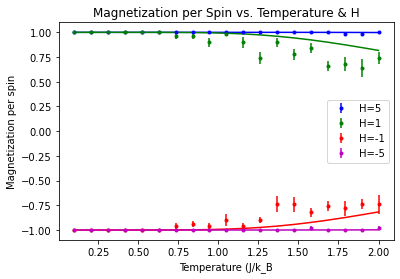

In [17]:
plt.figure()

#simulation results
plt.errorbar(x=temperatures, y=mag_5, yerr=mag_unc_5, label="H=5", color='b', marker='.', ls='')
plt.errorbar(x=temperatures, y=mag_1, yerr=mag_unc_1, label="H=1", color='g', marker='.', ls='')
plt.errorbar(x=temperatures, y=mag_minus1, yerr=mag_unc_minus1, label="H=-1", color='r', marker='.', ls='')
plt.errorbar(x=temperatures, y=mag_minus5, yerr=mag_unc_minus5, label="H=-5", color='m', marker='.', ls='')

#expectation values
plt.plot(temperatures, expected5, color='b')
plt.plot(temperatures, expected1, color='g')
plt.plot(temperatures, expected_minus1, color='r')
plt.plot(temperatures, expected_minus5, color='m')

plt.title("Magnetization per Spin vs. Temperature & H")
plt.xlabel("Temperature (J/k_B")
plt.ylabel("Magnetization per spin")
plt.legend()

plt.show()

This plot shows that at high values of H the spins in the Ising Model tend to all align in the direction of the external field.

<h2>2-Dimensional Ising Model</h2>

The Monte Carlo algorithm for simulating the two-dimensional Ising model is nearly identical to that for the one-dimensional case, the only differences being that we iterate through a two-dimensional numpy array and each spin now has four nearest neighbors to consider when calculationg the energy change. We are using the nearest neighbours approximation for the Ising model.

We will take this time to introduce the critical exponents of the Ising model:

<h4>Setup</h4>

In [18]:
def init_grid_2d(rows, cols=None):
    """ (int, int) -> (np.array)
    Creates an 2-dimensional numpy array with rows*cols entries of randomly chosen +1 and -1 spins.
    """
    if cols is None: #square grid
        cols = rows

    grid = []
    for i in range(rows): #numer of rows
        grid.append([random.randrange(-1, 2, 2) for j in range(cols)]) 
    return np.array(grid)

def total_mag_2d(grid):
    """ (np.array) -> (int)
    Calculates the total magnetization of a 2-dimensional grid of +1/-1 spins.
    """
    tot = 0
    for row in grid:
        tot += sum(row)
    return tot

def mag_per_spin_2d(grid):
    """ (np.array) -> (float)
    Calculates the magnetization per spin of a 2-dimensional grid of +1/-1 spins.
    """
    tot = total_mag_2d(grid)
    size = len(grid)*len(grid[0]) #rows*columns
    return tot/size

def print_grid_2d(grid):
    """ (np.array) -> (None)
    Prints a visulation of the 2-dimensional grid given as input.
    """
    for row in grid:
        print_grid_1d(row)

In [19]:
def energy_change_2d(grid, row_idx, col_idx, H=0):
    """ (np.array, int, int, float) -> (int)
    Calculates the energy change associated with flipping the spin at the idx position. The change is in units of J.
    H is the external field pointing in either the positive or negative direction also in units of J.
    """
    num_rows = len(grid)
    num_cols = len(grid[0])

    E = 0 #energy change

    E += 2*H*grid[row_idx][col_idx] #change due to external field
    
    #change due to horizontal neighbours with periodic boundary conditions
    E += 2*grid[row_idx][col_idx]*grid[row_idx][(col_idx+1)%num_cols] 
    E += 2*grid[row_idx][col_idx]*grid[row_idx][(col_idx-1)%num_cols]

    #change due to vertical neighbours with periodic boundary conditions
    E += 2*grid[row_idx][col_idx]*grid[(row_idx+1)%num_rows][col_idx] 
    E += 2*grid[row_idx][col_idx]*grid[(row_idx-1)%num_rows][col_idx]

    return E 



def glauber_2d(grid, row_idx, col_idx, temp, H=0):
    """ (np.array, int, int, float, float) -> (float)
    Calculates the probability that a change of state of a 2-dimensional grid, with energy change given by energy, will occur at a given temperature, temp. The probability is calculated using the Glauber rule. 
    """
    energy = energy_change_2d(grid, row_idx, col_idx, H)
    return 0.5*(1 - tanh(0.5*energy/temp))


def metropolis_2d(grid, row_idx, col_idx, temp, H=0):
    """ (np.array, int, int, float, float) -> (float)
    Calculates the probability that a change of state of a 2-dimensional grid, with energy change given by energy, will occur at a given temperature, temp. The probability is calculated using the Metropolis rule. 
    """
    energy = energy_change_2d(grid, row_idx, col_idx, H)
    if energy <= 0:
        return 1
    return exp(-energy/temp)


def flip_2d(grid, row_idx, col_idx, temp, H=0, rule="metropolis"):
    """ (np.array, int, int, float, float, str) -> ()
    Flips the spin in grid at site idx with a probability given by the Metropolis or Glauber rule at temperature temp.
    """
    if rule == "glauber":
        prob = glauber_2d(grid, row_idx, col_idx, temp, H)
    elif rule == "metropolis":
        prob = metropolis_2d(grid, row_idx, col_idx, temp, H)
    else:
        raise ValueError("The rule argument take \"glauber\" or \"metropolis\" as input.")

    choice = random.uniform(0, 1)
    
    if choice <= prob: #will flip
        grid[row_idx][col_idx] *= -1
    #otherwise will not flip and nothing happens


def cycle_2d(grid, temp, H=0):
    """ (np.array, float, float) -> ()
    Will conduct one Monte Carlo cycle over grid at temperature temp. 
    """
    num_row = len(grid)
    num_col = len(grid[0])

    for row_idx in range(num_row):
        for col_idx in range(num_col):
            flip_2d(grid, row_idx, col_idx, temp, H)


def simulation_2d(grid, temp, H=0):
    """ (np.array, float, float) -> ()
    Will conduct one Monte Carlo simulation over grid at temperature temp. 
    """
    size = len(grid)*len(grid[0]) #N Monte Carlo cycles for N sites is one simulation
    for i in range(size):
        cycle_2d(grid, temp, H)

<h4>Simulation</h4>

We will create a two-dimensional numpy array of NxM sites and run a total of num_sim Monte Carlo simulations before recording the magnetization per spin. We will do this num_points times, to get that many data points, at each temperature T in temperatues. Increasing num_points will get us a more precise measurement of the magnetization per spin at different temperatures. Increasing num_sim will let our experimental results approach the long-time thermodynamic limit 

In [20]:
def full_sim_2d(rows, cols, num_points, num_sim, temperatures, H=0):
    """ (int, int, int, int, np.array, float) -> (list, list)
    rows: total number of rows
    cols: total number of columns
    num_points: number of data points at each temperature
    num_sim: total numer of simulations conducted on a strip
    temperatures: range of temperatues at which we will simulate
    H: the strength of the external field
     
    """
    magnetizations = [] #<m> of our simulations at various temperatues
    magnetizations_unc = [] #uncertainties in <m>

    for T in temperatures:
        m_at_t = []
        for i in range(num_points): #we do num_points simulations at each temperature for that many data points
            grid = init_grid_2d(N)
            for i in range(num_sim): #we do num_sim simulations for each grid
                simulation_2d(grid, T, H)
            m_at_t.append(mag_per_spin_2d(grid))
        magnetizations.append(mean(m_at_t))
        magnetizations_unc.append(standard_error(m_at_t))
    return magnetizations, magnetizations_unc

<h4>H=0</h4>

<h2>Sources</h2>

* Grant, Martin. <em>Dirty tricks for statistical mechanics</em>. 2004.
    * Available here: http://www.physics.mcgill.ca/~grant/559/notes0.91.pdf
* Holmes-Cerfon, Miranda. <em>Lecture 3: Markov Chains (II): Detailed Balance, and Markov Chain Monte Carlo (MCMC)</em>. 2019.
    * Available here: https://cims.nyu.edu/~holmes/teaching/asa19/handout_Lecture3_2019.pdf
* Hott, Michael. <em>The solution of the 2D Ising model</em>. 2013. Karlsruher Institut f&#252;r Technologie, Bacelor thesis.
    * Available here: https://web.ma.utexas.edu/users/mhott/Extra%20material/bachelorthesis.pdf
* Onsager, Lars. <em>Crystal Statistics. I. A Two-Dimensional Model with an Order-Disorder Transition.</em> Physical Review, vol. 65, no. 3, 1 Feb. 1944, pp. 117–149. 
    * Available here: http://www.phys.ens.fr/~langlois/Onsager43.pdf
* Pathria, R. K., and Paul D. Beale. <em>Statistical Mechanics</em>. Elsevier, 2011. 
* Salinas S.R.A. <em>Introduction to Statistical Physics</em>. 2001. Graduate Texts in Contemporary Physics. Springer, New York, NY. https://doi.org/10.1007/978-1-4757-3508-6_13
    * Relevant chapter available here: http://www.lps.ens.fr/~krzakala/ISINGMODEL.pdf





<h2>Rough Work</h2>

In [23]:
import time

start_time = time.time()

grid = init_grid_1d(10)
for i in range(10000):
    for idx in range(10):
        flip_1d(grid, idx, 1, 0, 'glauber')

print("Glauber takes:", time.time()-start_time)

start_time = time.time()

grid = init_grid_1d(10)
for i in range(10000):
    for idx in range(10):
        flip_1d(grid, idx, 1, 0, 'metropolis')

print("Met takes:", time.time()-start_time)

Glauber takes: 0.41122865676879883
Met takes: 0.20813465118408203
